In [1]:
# pip install tqdm

In [2]:
# pip install yfinance

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from decimal import ROUND_HALF_UP, Decimal
from tqdm import tqdm
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns 

In [4]:
df_raw = yf.download("^HSI", start="1987-01-01", end="2023-01-01").droplevel('Ticker', axis=1)

/var/folders/k0/qltbxq952h32hdmn8lyxcsnh0000gn/T/ipykernel_22387/21432267.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_raw = yf.download("^HSI", start="1987-01-01", end="2023-01-01").droplevel('Ticker', axis=1)
[*********************100%***********************]  1 of 1 completed


## DF Cleaning & Trimming 

In [5]:
data = df_raw.copy().drop(columns=['Volume']).dropna()
data.sample(3)

Price,Close,High,Low,Open
Date,,,,
2012-01-30,20160.410156,20518.000000,20144.949219,20518.000000
2000-03-17,17082.990234,17096.000000,16617.179688,16688.039062
1992-01-08,4337.700195,4373.700195,4328.500000,4347.899902


## Add features

In [6]:
def cal(x: int):
    return x**2


In [7]:
def add_features(feats: pd.DataFrame) -> pd.DataFrame:
    for i in [20, 60]:
        feats[f"MA_{i}"] = feats["Close"].rolling(i).mean()
    
    feats['simple_rtn'] = feats.Close.pct_change()
    feats['log_rtn'] = np.log(feats.Close/feats.Close.shift(1))
    feats["volatility_20"] = np.log(feats["Close"]).diff().rolling(20).std()
    feats['log_rtn_20'] = np.log(feats.Close/feats.Close.shift(20))
    return feats

data = add_features(data).dropna()

In [8]:
data

Price,Close,High,Low,Open,MA_20,MA_60,simple_rtn,log_rtn,volatility_20,log_rtn_20
Date,,,,,,,,,,
1987-03-30,2774.899902,2774.899902,2774.899902,2774.899902,2778.260010,2698.976664,-0.008504,-0.008540,0.017323,-0.042129
1987-03-31,2713.800049,2713.800049,2713.800049,2713.800049,2766.995007,2701.871663,-0.022019,-0.022265,0.017369,-0.079754
1987-04-01,2695.899902,2695.899902,2695.899902,2695.899902,2757.245007,2704.263330,-0.006596,-0.006618,0.017132,-0.069836
1987-04-02,2709.399902,2709.399902,2709.399902,2709.399902,2752.795007,2706.354997,0.005008,0.004995,0.015787,-0.032321
1987-04-03,2680.000000,2680.000000,2680.000000,2680.000000,2746.865002,2707.569995,-0.010851,-0.010910,0.015916,-0.043303
...,...,...,...,...,...,...,...,...,...,...
2022-12-22,19679.220703,19735.000000,19475.679688,19537.449219,19052.523438,17491.363623,0.027073,0.026713,0.022045,0.108210
2022-12-23,19593.060547,19686.769531,19380.470703,19382.230469,19153.497461,17531.816813,-0.004378,-0.004388,0.022031,0.108779
2022-12-28,19898.910156,20099.769531,19787.939453,19787.939453,19283.545996,17576.418148,0.015610,0.015490,0.021549,0.140078


In [9]:
colors=px.colors.qualitative.Plotly

fig = make_subplots(rows=3, cols=1, shared_xaxes=True)
for i, j in enumerate([data.simple_rtn, data.log_rtn, data.Close]):
    fig.add_trace(go.Scatter(x=data.index, y=j, mode='lines',
                name=j.name, marker_color=colors[i]), row=i+1, col=1)
fig.show()

## Detecting outliers using the 3σ approach

In [10]:
data[['simple_rtn']].rolling(20).agg(['mean', 'std'])

Price      simple_rtn          
                 mean       std
Date                           
1987-03-30        NaN       NaN
1987-03-31        NaN       NaN
1987-04-01        NaN       NaN
1987-04-02        NaN       NaN
1987-04-03        NaN       NaN
...               ...       ...
2022-12-22   0.005658  0.022276
2022-12-23   0.005686  0.022262
2022-12-28   0.007251  0.021776
2022-12-29   0.004234  0.019219
2022-12-30   0.003258  0.018783

[8831 rows x 2 columns]

In [11]:
df_rolling = data[['simple_rtn']].rolling(20).agg(['mean', 'std'])
df_rolling.columns = df_rolling.columns.droplevel()
df_outliers = data.join(df_rolling)

In [12]:
def identify_outliers(row, n_sigmas=3):
    x = row['simple_rtn']
    mu = row['mean']
    sigma = row['std']
    if (x > mu + 3 * sigma) | (x < mu - 3 * sigma):
        return 1
    else:
        return 0

In [13]:
df_outliers['outlier'] = df_outliers.apply(identify_outliers,  axis=1)
outliers = df_outliers.loc[df_outliers['outlier'] == 1, ['simple_rtn']]
outliers.sample(5)

,simple_rtn
Date,
2012-11-08,-0.024115
2015-04-08,0.038029
1996-03-11,-0.073125
2015-08-24,-0.051676
1998-08-14,0.084720


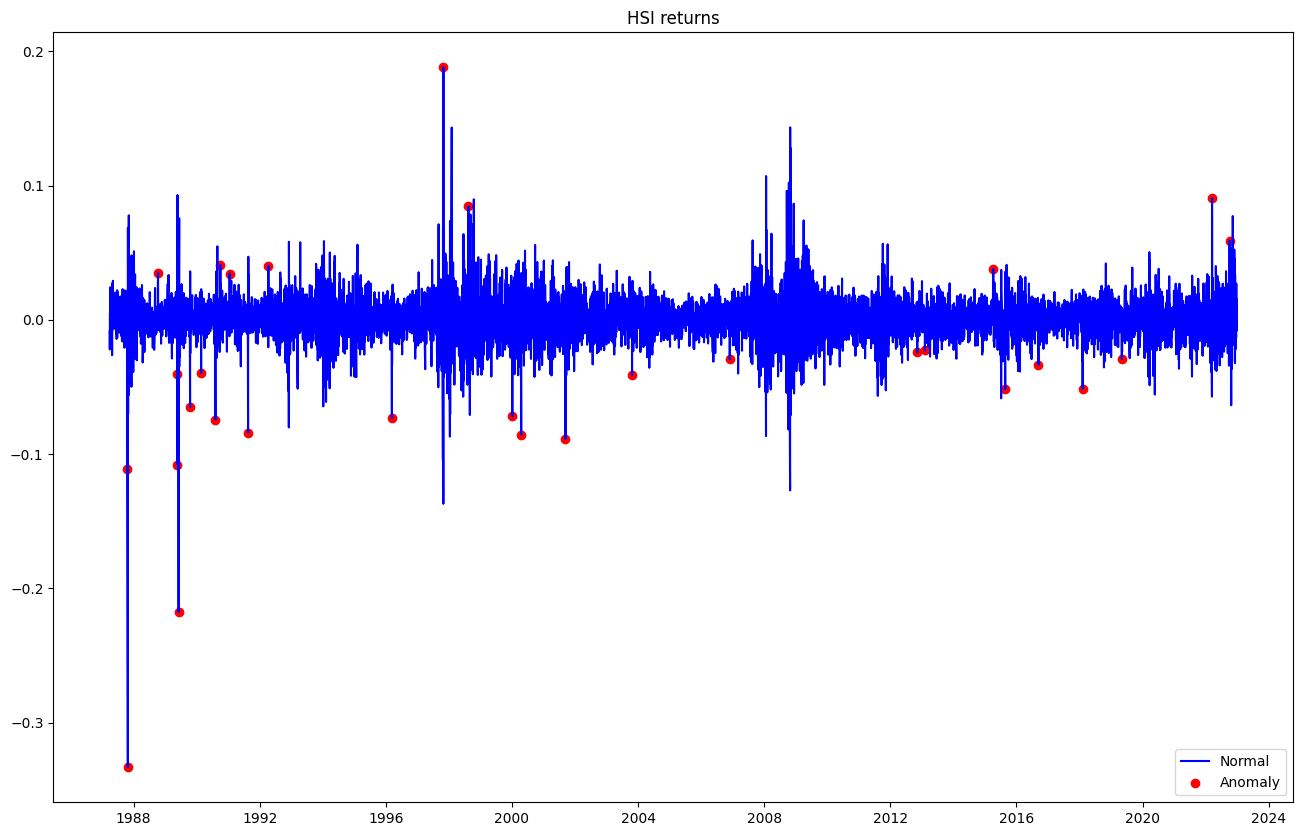

In [14]:
fig, ax = plt.subplots(figsize=(16,10))

ax.plot(df_outliers.index, df_outliers.simple_rtn, 
        color='blue', label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn, 
           color='red', label='Anomaly')
ax.set_title("HSI returns")
ax.legend(loc='lower right')

plt.show()

## Investigate asset return

In [15]:
data.describe()

Price,Close,High,Low,Open,MA_20,MA_60,simple_rtn,log_rtn,volatility_20,log_rtn_20
count,8831.000000,8831.000000,8831.000000,8831.000000,8831.000000,8831.000000,8831.000000,8831.000000,8831.000000,8831.000000
mean,15612.443663,15720.119223,15497.615653,15618.671179,15594.402424,15560.239481,0.000355,0.000221,0.013847,0.004399
std,8070.968662,8121.320067,8020.180748,8078.956669,8068.342257,8065.845157,0.016228,0.016450,0.008838,0.075487
min,1894.900024,1950.500000,1894.900024,1950.500000,2085.339990,2220.491661,-0.333304,-0.405420,0.003966,-0.700236
25%,9493.165039,9569.250000,9416.470215,9494.599609,9471.997485,9499.276693,-0.006752,-0.006775,0.008813,-0.032728
50%,15070.559570,15192.919922,14936.900391,15075.780273,15058.706934,15019.605973,0.000551,0.000551,0.011381,0.009794
75%,22668.540039,22808.315430,22541.815430,22697.649414,22601.260791,22643.067643,0.007985,0.007953,0.015852,0.048447
max,33154.121094,33484.078125,32897.039062,33335.480469,32213.191504,31275.259961,0.188236,0.172470,0.100805,0.328689


In [16]:
# Probability Density Function (PDF) using the mean and standard deviation of the observed returns:
mu = data.log_rtn.mean()
sigma = data.log_rtn.std()
norm_pdf = np.random.normal(loc=mu, scale=sigma, size=8831) 

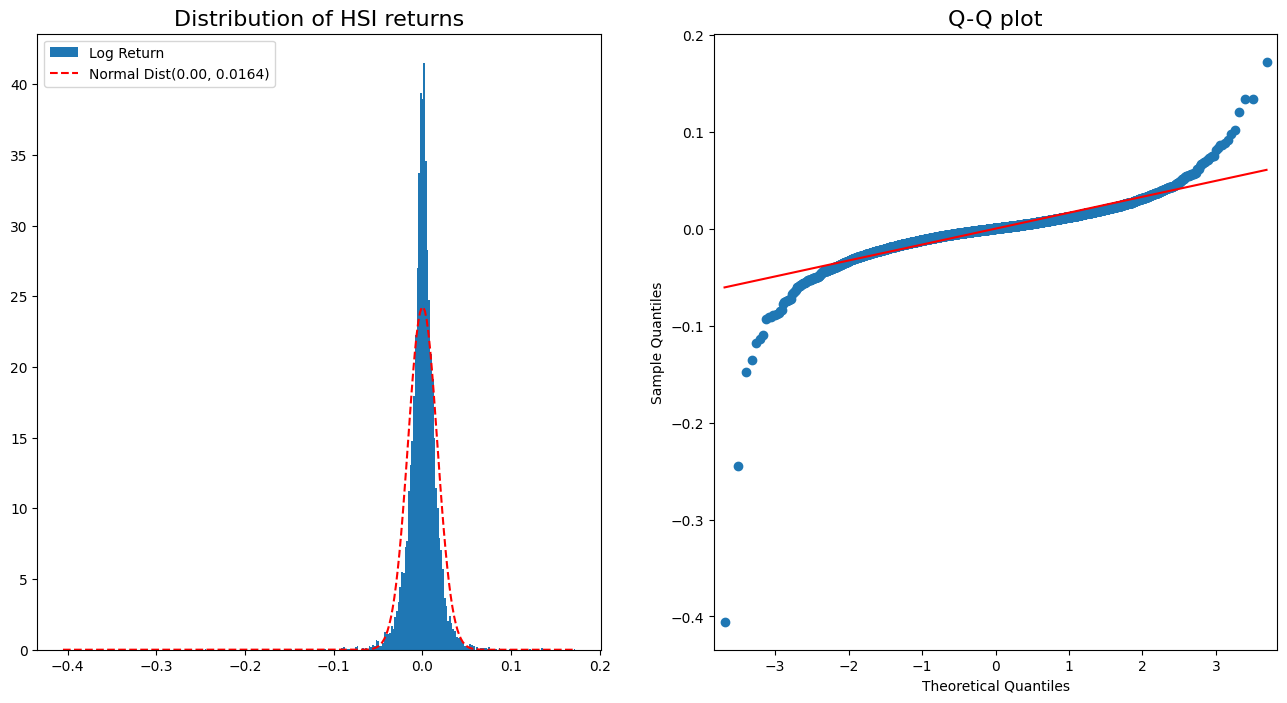

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
num_bins = 300

# histogram
ax[0].set_title('Distribution of HSI returns', fontsize=16)      
n, bins, patches = ax[0].hist(data.log_rtn, num_bins, density=True, label='Log Return')

# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))

ax[0].plot(bins, y, 'r--',  label=f'Normal Dist({mu:.2f}, {sigma:.4f})')
ax[0].legend(loc='upper left');

# Q-Q plot
qq = sm.qqplot(data.log_rtn.values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 16)

plt.show()

## Using last 250 days sample

In [18]:
mu = data.iloc[-250:].log_rtn.mean()
sigma = data.iloc[-250:].log_rtn.std()
norm_pdf = np.random.normal(loc=mu, scale=sigma, size=8831) 

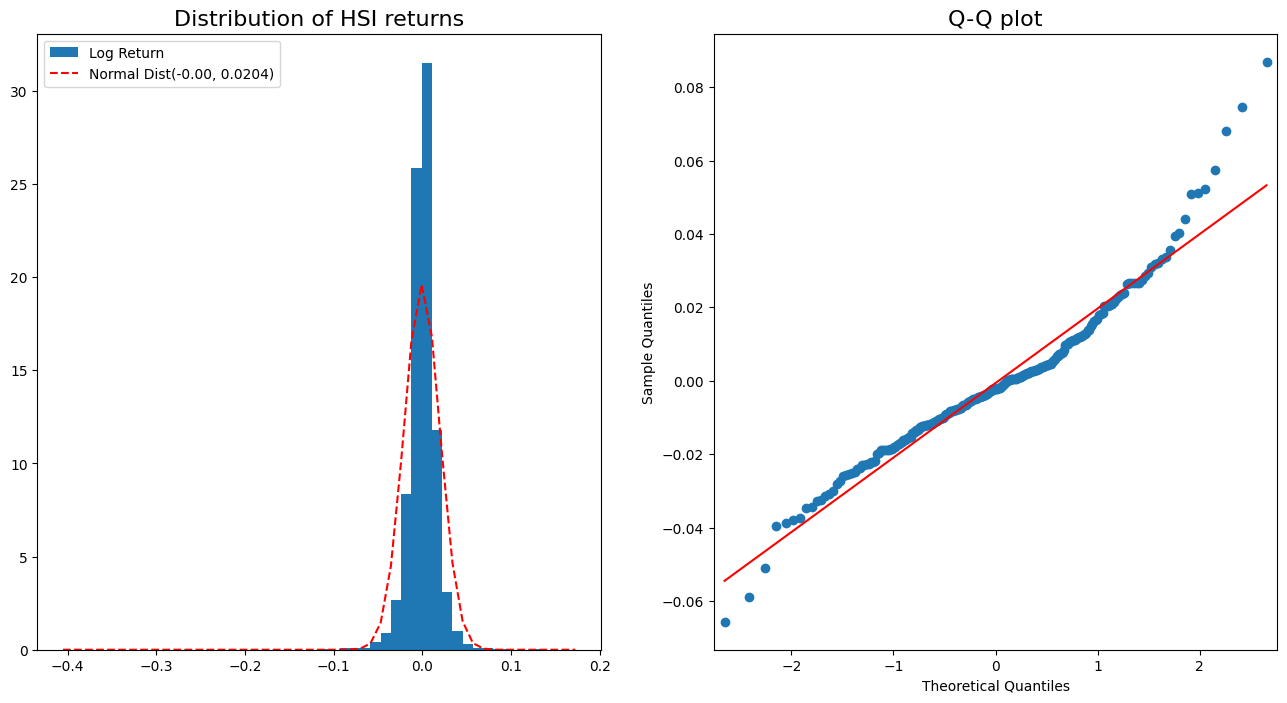

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

num_bins = 50

# histogram
ax[0].set_title('Distribution of HSI returns', fontsize=16) 
n, bins, patches = ax[0].hist(data.log_rtn, num_bins, density=True, label='Log Return')
# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))

ax[0].plot(bins, y, 'r--',  label=f'Normal Dist({mu:.2f}, {sigma:.4f})')
ax[0].legend(loc='upper left');

# Q-Q plot
qq = sm.qqplot(data.iloc[-250:].log_rtn.values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 16)

plt.show()

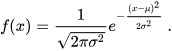

In [20]:
print('---------- Descriptive Statistics ----------')
print('Range of dates:', min(data.iloc[-250:].index.date), '-', max(data.iloc[-250:].index.date))
print('Number of observations:', data.iloc[-250:].shape[0])
print(f'Mean: {data.iloc[-250:].log_rtn.mean():.4f}')
print(f'Median: {data.iloc[-250:].log_rtn.median():.4f}')
print(f'Min: {data.iloc[-250:].log_rtn.min():.4f}')
print(f'Max: {data.iloc[-250:].log_rtn.max():.4f}')
print(f'Standard Deviation: {data.iloc[-250:].log_rtn.std():.4f}')
print(f'Skewness: {data.iloc[-250:].log_rtn.skew():.4f}')
print(f'Kurtosis: {data.iloc[-250:].log_rtn.kurtosis():.4f}') 

---------- Descriptive Statistics ----------
Range of dates: 2021-12-28 - 2022-12-30
Number of observations: 250
Mean: -0.0006
Median: -0.0022
Min: -0.0657
Max: 0.0869
Standard Deviation: 0.0204
Skewness: 0.7131
Kurtosis: 2.5186


In [21]:
data.iloc[-250:].log_rtn.describe()

count    250.000000
mean      -0.000642
std        0.020352
min       -0.065673
25%       -0.012060
50%       -0.002249
75%        0.008313
max        0.086928
Name: log_rtn, dtype: float64

## Log Return vs Volatility

Volatilaty or Standard Deviation means risk in finance. We can investigate the return vs volatility

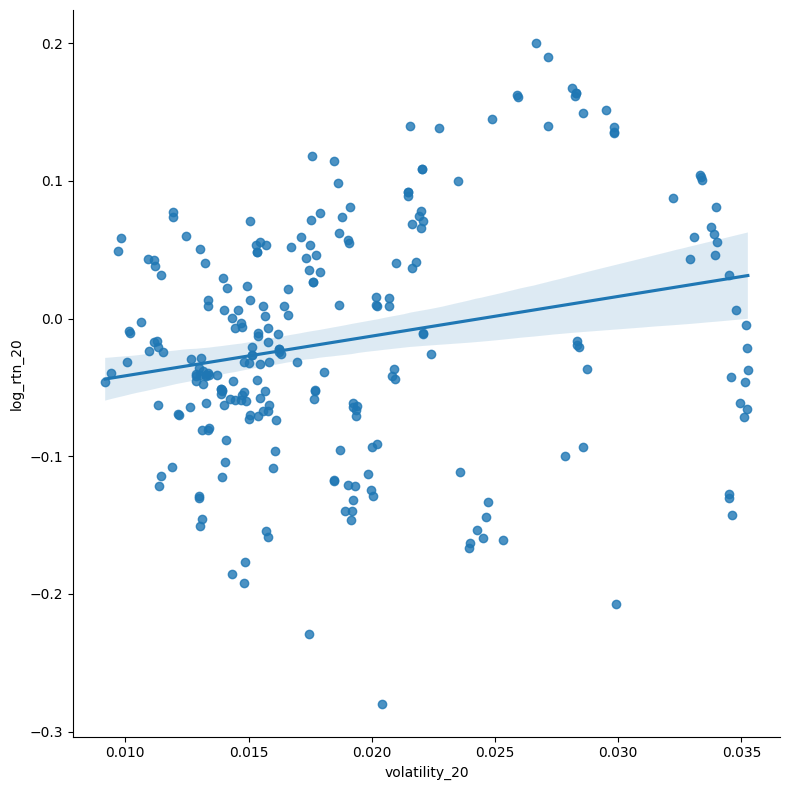

In [22]:
sns.lmplot(data=data.iloc[-250:], x="volatility_20", y="log_rtn_20", height=8)

In [23]:
print("Correlation between return and volatility:",
      data.iloc[-250:].volatility_20.corr(data.iloc[-250:].log_rtn_20))

Correlation between return and volatility: 0.22993256556828837


## Autocorrelation

In [24]:
import statsmodels.tsa.api as smt
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05

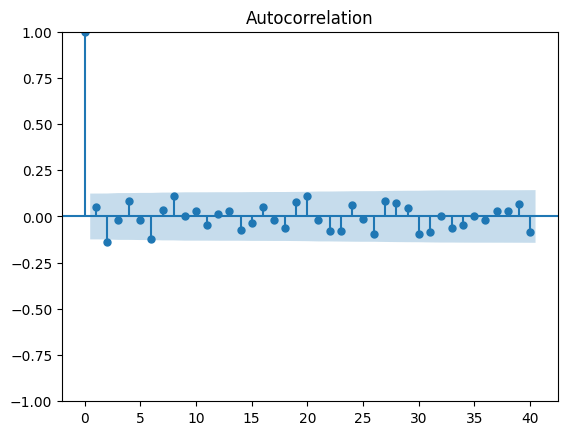

In [25]:
acf = smt.graphics.plot_acf(data.iloc[-250:].log_rtn, 
                            lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)

In [26]:
print("Autocorrelation of log return inlast 250-days: ",
      data.iloc[-250:].log_rtn.autocorr(lag=1))

Autocorrelation of log return inlast 250-days:  0.05060587450032969


In [27]:
print("Autocorrelation of log return in all years: ",
      data.log_rtn.autocorr(lag=1))

Autocorrelation of log return in all years:  0.01934015691922654


In [28]:
data.iloc[-250:].Close.autocorr(lag=1)

0.9855952143997877

## Sharpe Ratio

In [29]:
hsbc = yf.download("0005.HK", start="2022-01-01", end="2023-01-01").droplevel('Ticker', axis=1)
citic = yf.download("0998.HK", start="2022-01-01", end="2023-01-01").droplevel('Ticker', axis=1)

/var/folders/k0/qltbxq952h32hdmn8lyxcsnh0000gn/T/ipykernel_22387/3550665843.py:1: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/var/folders/k0/qltbxq952h32hdmn8lyxcsnh0000gn/T/ipykernel_22387/3550665843.py:2: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


In [30]:
def cal_sharpe(df):
    rf_rate = 0.01
    log_ret_annual = np.log(df.Close[df.index[-1]] / df.Close[df.index[0]])
    df['log_ret_daily'] = np.log(df.Close/df.Close.shift(1))
    df = df.dropna()
    sharpe = (log_ret_annual - rf_rate) / (df.log_ret_daily.std()* np.sqrt(252))
    return f"Sharpe Ratio: {sharpe:.4f}, Annual Log Return: {log_ret_annual:.4f}"

In [31]:
print("HSBC: ", cal_sharpe(hsbc))
print("CITIC: ", cal_sharpe(citic))

HSBC:  Sharpe Ratio: 0.2267, Annual Log Return: 0.0784
CITIC:  Sharpe Ratio: 0.5376, Annual Log Return: 0.1187


# Calculate 3 years annualised sharpe ratio

In [32]:
STARTDAY='2022-11-02' 
ENDDAY='2024-11-02'
ticker = '0005.HK'
RF_rate = 0.03  # Risk Free rate, ie HK government bond rate

def calSharpe(ticker, ):
    """Calculate Sharpe Ratio and mean adjusted Sharpe Ratio"""
    _close = yf.download(ticker, start=STARTDAY, end=ENDDAY, progress=False).droplevel(1, axis=1)['Close']
    _logRetDaily = np.log(_close/_close.shift(1))
    _logRetDaily.dropna(inplace=True)    

    _sharpe = ((_close.iloc[-1]/_close.iloc[0] - RF_rate)**(252/_close.size) -1)  / (_logRetDaily.std() * np.sqrt(252))
    _sharpe_modified = (_logRetDaily.mean()* 252 - RF_rate)  / (_logRetDaily.std() * np.sqrt(252))
    
    return f"Sharpe Ratio: {_sharpe:.4f}, Modified Sahrpe Ratio: {_sharpe_modified:.4f}"

calSharpe(ticker)

/var/folders/k0/qltbxq952h32hdmn8lyxcsnh0000gn/T/ipykernel_22387/1416277242.py:8: FutureWarning:

YF.download() has changed argument auto_adjust default to True



'Sharpe Ratio: 2.1113, Modified Sahrpe Ratio: 1.6517'

In [33]:
import numpy as np
mu = 0
sigma = 0.02
rand_data = pd.DataFrame({'Return':np.random.normal(mu, sigma, 100_000)})
norm_pdf = np.random.normal(mu, sigma, 100_000) 

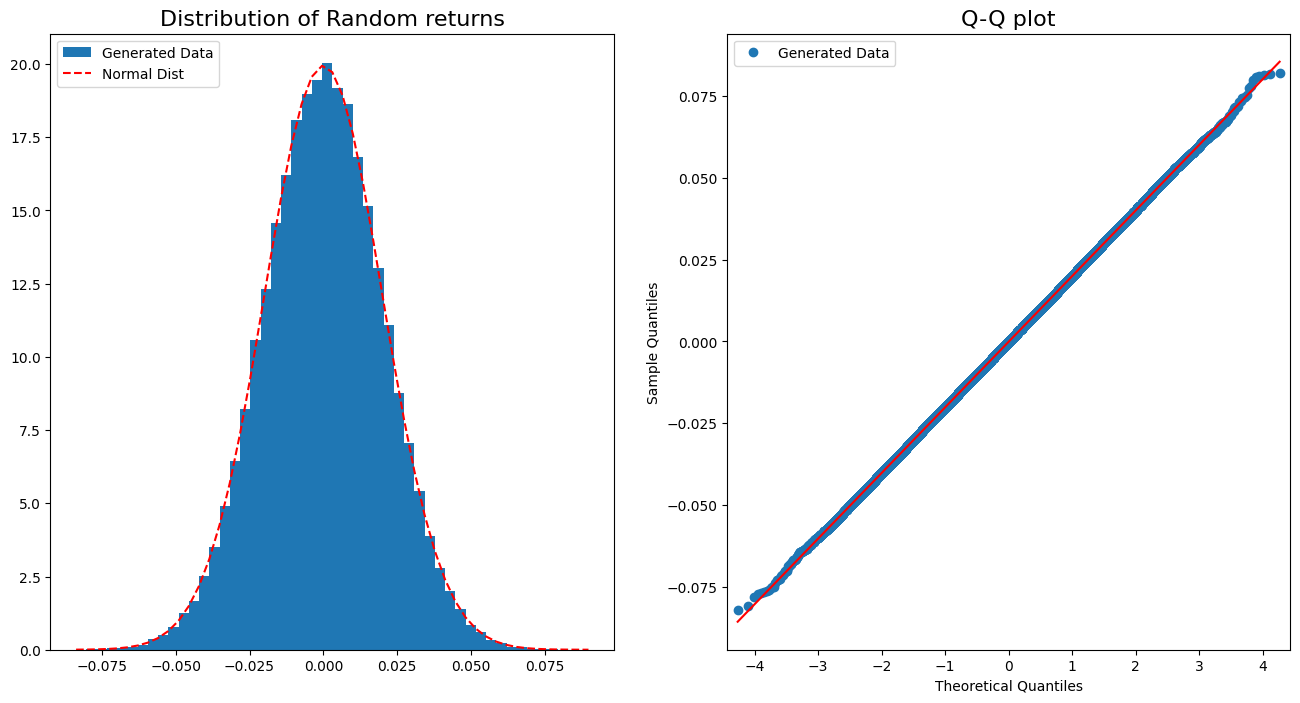

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
num_bins = 50
x = np.random.normal(mu, sigma, 100_000) 

# add a 'best fit' line
n, bins, patches = ax[0].hist(x, num_bins, density=True, label='Generated Data')
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))

# histogram
ax[0].set_title('Distribution of Random returns', fontsize=16)      
ax[0].plot(bins, y, 'r--',  label='Normal Dist')
ax[0].legend(loc='upper left')

# Q-Q plot
qq = sm.qqplot(rand_data['Return'].values, line='s', ax=ax[1], label='Generated Data')
ax[1].set_title('Q-Q plot', fontsize = 16)
ax[1].legend(loc='upper left')

plt.show()